Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking
using CmdStan, StanMCMCChain
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "04")
cd(ProjDir)

### snippet 4.7

In [3]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df);
first(df2, 5)

5×4 DataFrame
│ Row │ height   │ weight   │ age      │ male   │
│     │ Float64⍰ │ Float64⍰ │ Float64⍰ │ Int64⍰ │
├─────┼──────────┼──────────┼──────────┼────────┤
│ 1   │ 151.765  │ 47.8256  │ 63.0     │ 1      │
│ 2   │ 139.7    │ 36.4858  │ 63.0     │ 0      │
│ 3   │ 136.525  │ 31.8648  │ 65.0     │ 0      │
│ 4   │ 156.845  │ 53.0419  │ 41.0     │ 1      │
│ 5   │ 145.415  │ 41.2769  │ 51.0     │ 0      │

Define the Stan language model

In [5]:
weightsmodel = "
data {
 int < lower = 1 > N; // Sample size
 vector[N] height; // Predictor
 vector[N] weight; // Outcome
}

parameters {
 real alpha; // Intercept
 real beta; // Slope (regression coefficients)
 real < lower = 0 > sigma; // Error SD
}

model {
 height ~ normal(alpha + weight * beta , sigma);
}

generated quantities {
}
";

Define the Stanmodel and set the output format to :mcmcchain.

In [6]:
stanmodel = Stanmodel(name="weights", monitors = ["alpha", "beta", "sigma"],model=weightsmodel,
  output_format=:mcmcchain);
# Input data for cmdstan
heightsdata = Dict("N" => length(df2[:height]), "height" => df2[:height],
  "weight" => df2[:weight]);
# Sample using cmdstan
rc, chn, cnames = stan(stanmodel, heightsdata, ProjDir, diagnostics=false,
  summary=false, CmdStanDir=CMDSTAN_HOME)
# Show first 5 individual draws of correlated parameter values in chain 1
chn.value[1:5,:,1]

5×3 Array{Union{Missing, Float64},2}:
 114.19   0.889918  5.27482
 114.091  0.887026  5.27279
 114.07   0.884054  5.2795 
 114.706  0.903283  5.23673
 112.196  0.933242  4.97052

Plot estimates using the N = [10, 50, 150, 352] observations

In [7]:
p = Vector{Plots.Plot{Plots.GRBackend}}(undef, 4)
nvals = [10, 50, 150, 352];

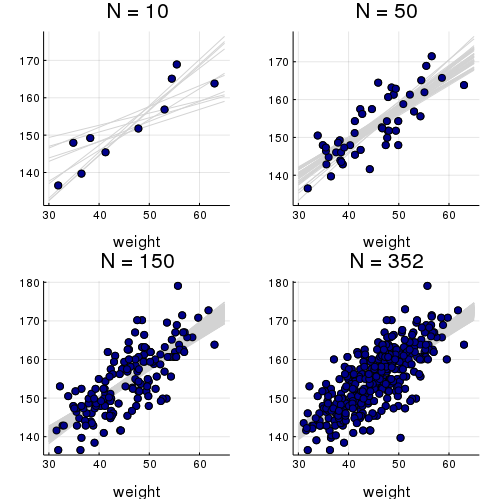

In [8]:
for i in 1:length(nvals)
  N = nvals[i]
  heightsdataN = [
    Dict("N" => N, "height" => df2[1:N, :height], "weight" => df2[1:N, :weight])
  ]
  rc, chnN, cnames = stan(stanmodel, heightsdataN, ProjDir, diagnostics=false,
    summary=false, CmdStanDir=CMDSTAN_HOME)

  xi = 30.0:0.1:65.0
  rws, vars, chns = size(chnN[:, 1, :])
  alpha_vals = convert(Vector{Float64}, reshape(chnN.value[:, 1, :], (rws*chns)))
  beta_vals = convert(Vector{Float64}, reshape(chnN.value[:, 2, :], (rws*chns)))

  p[i] = scatter(df2[1:N, :weight], df2[1:N, :height], leg=false,
    color=:darkblue, xlab="weight")
  for j in 1:N
    yi = alpha_vals[j] .+ beta_vals[j]*xi
    plot!(p[i], xi, yi, title="N = $N", color=:lightgrey)
  end
  scatter!(p[i], df2[1:N, :weight], df2[1:N, :height], leg=false,
    color=:darkblue, xlab="weight")
end
plot(p..., layout=(2, 2))

End of `clip_45_47s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*